RFM Segmentation:

Different companies may use different types of segmentation based on their needs and purposes. One of the most common ways to segment customers based on the value they generate is RFM segmentation. RFM segmentation is very straightforward and easy to understand, and it can help you learn about customer's purchasing behavior.
RFM stands for Recency, Frequency, and Monetary. These are three metrics that measure how recently, how often, and how much a customer has purchased from a company.
Some people choose to use quartiles to segment customers based on these metrics, but I chose to use K-means clustering method. I chose this method because using quartiles would result in 5*5*5 groups that we have to group them manually, and I find that sometimes hard to comprehend and present to other teams.

Import libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from feature_engine.outliers import Winsorizer
import plotly.offline as pyoff
import plotly.graph_objs as go
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [53]:
# Load Dataset
df = pd.read_csv('Online Retail.csv',encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Attribute Information:

InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.

UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).

CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal. The name of the country where a customer resides.


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [55]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [56]:
df.loc[(df.UnitPrice<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


UnitPrice has negative values for two records, which might indicate that a discount or a voucher was applied.


In [57]:
df.loc[(df.Quantity<0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In this case, a negative quantity may indicate returned items. We can ignore them for now.

In [58]:
df = df[df.Quantity > 0]
df = df[df.UnitPrice > 0]

#Removing the Null values from the data.
df = df[pd.notnull(df['CustomerID'])]

In [59]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [60]:
item_sold = df.groupby('InvoiceYearMonth').sum('Quantity')[['Quantity']]
fig = px.line(x = item_sold.index, y = item_sold.Quantity) 
fig.update_layout(xaxis_tickformat='%Y-%m')  # Format x-axis ticks as year-month
# trend of Quentity that has been sold

In [61]:
Revenue = df.groupby('InvoiceYearMonth').sum('UnitPrice')[['Quantity']]
fig = px.line(x = Revenue.index, y = Revenue.Quantity) 
fig.update_layout(xaxis_tickformat='%Y-%m')  # Format x-axis ticks as year-month


In [62]:
NOW = dt.date(2011,12,9) 
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [63]:
df_recency = df.groupby(['CustomerID'],as_index=False)['Date'].max()
df_recency.columns = ['CustomerID','Last_Purchase_Date']
df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [64]:
FM_Table = df.groupby('CustomerID').agg({'InvoiceNo'   : lambda x:len(x),                                         'UnitPrice'  : lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo' :'Frequency',                           'UnitPrice':'Monetary'},inplace= True)
FM_Table.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,1.04
12347.0,182,481.21
12348.0,31,178.71
12349.0,73,605.10
12350.0,17,65.30


In [65]:
RFM_Table = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM_Table.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,1.04
1,12347.0,2,182,481.21
2,12348.0,75,31,178.71
3,12349.0,18,73,605.10
4,12350.0,310,17,65.30


In [66]:
RFM_Table.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.059474,91.720609,285.846154
std,1721.808492,100.012264,228.785094,880.636531
min,12346.000000,0.000000,1.000000,0.170000
25%,13813.250000,17.000000,17.000000,51.725000
50%,15299.500000,50.000000,41.000000,127.290000
75%,16778.750000,141.750000,100.000000,294.452500
max,18287.000000,373.000000,7847.000000,33332.450000


In [67]:
px.scatter(x=RFM_Table.Monetary, y=RFM_Table.Frequency, color=RFM_Table.Recency)

In [68]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

vars = ['Recency', 'Frequency', 'Monetary']
fig = make_subplots(rows=1, cols=len(vars))
for i, var in enumerate(vars):
    fig.add_trace(
        go.Box(y=RFM_Table[var],
        name=var),
        row=1, col=i+1
    )

fig.show()

In [69]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return


Recency's: Skew: 1.2453948317057284, : SkewtestResult(statistic=26.60351236555474, pvalue=6.181721752536432e-156)
Frequency's: Skew: 18.09990377360193, : SkewtestResult(statistic=83.56042637346283, pvalue=0.0)
Monetary's: Skew: 22.894022838359014, : SkewtestResult(statistic=88.73711104335341, pvalue=0.0)


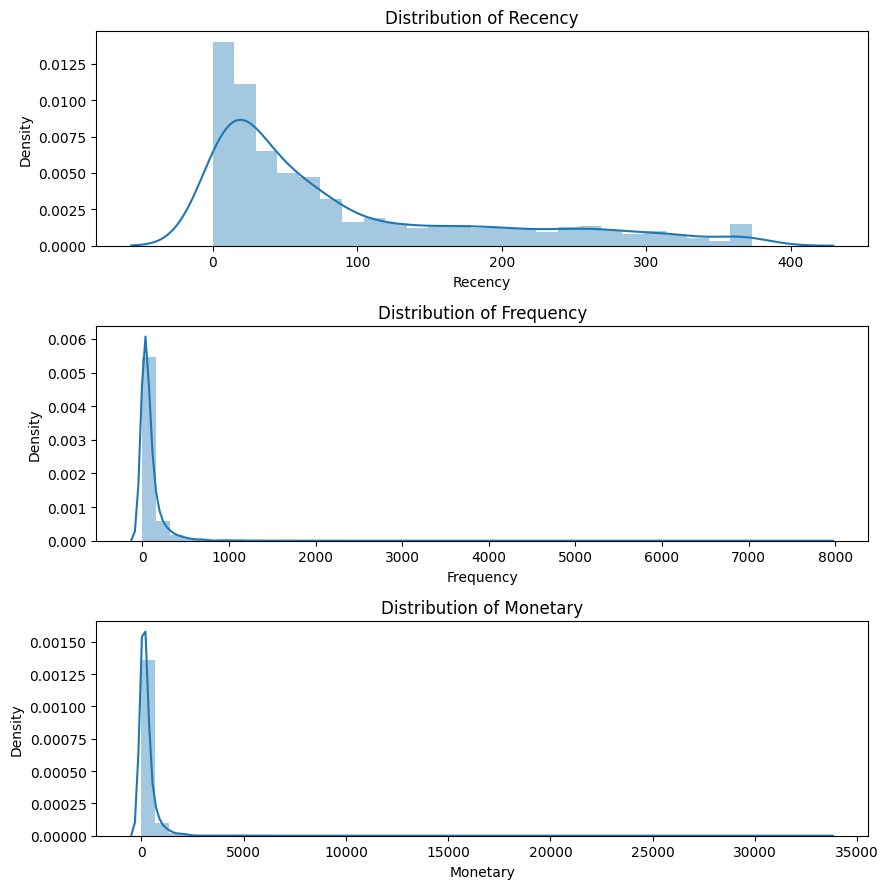

In [70]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary')

plt.tight_layout()

In [71]:
df_rfm_log = RFM_Table.copy()


In [72]:
df_rfm_log.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,1.04
1,12347.0,2,182,481.21
2,12348.0,75,31,178.71
3,12349.0,18,73,605.10
4,12350.0,310,17,65.30


Recency's: Skew: -0.4670749364137121, : SkewtestResult(statistic=-11.982131984493975, pvalue=4.4083870352936716e-33)
Frequency's: Skew: -0.014039824144133517, : SkewtestResult(statistic=-0.37814349655585117, pvalue=0.7053239974885566)
Monetary's: Skew: -0.28138316542308983, : SkewtestResult(statistic=-7.437215451259305, pvalue=1.0282976649166173e-13)


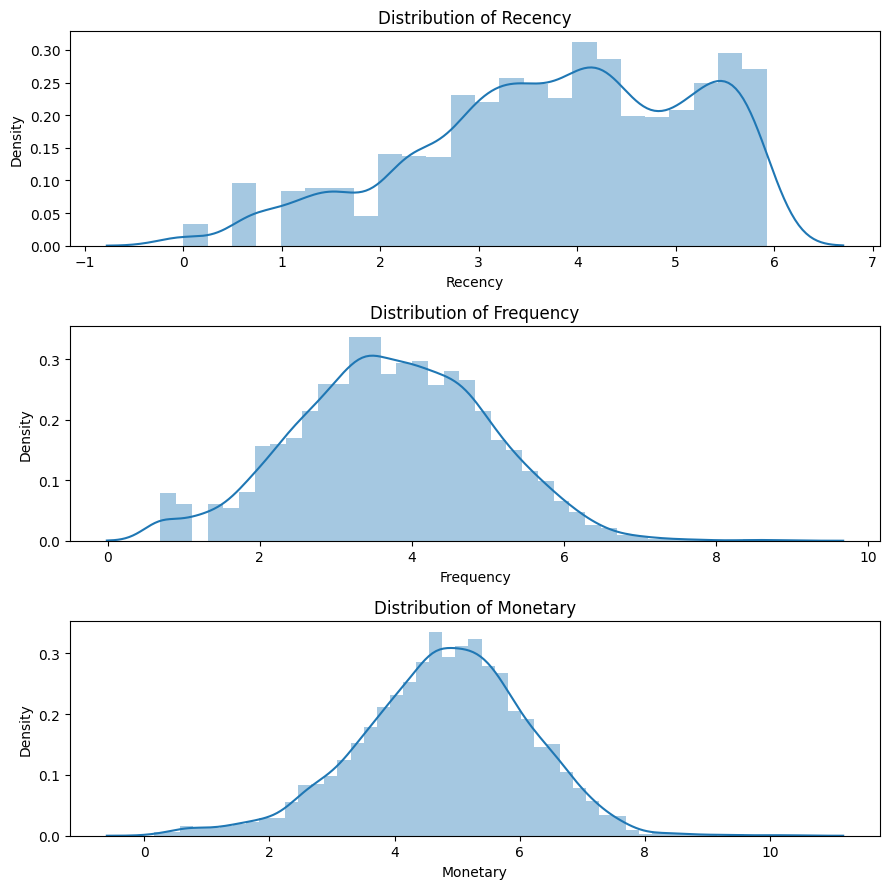

In [73]:
df_rfm_log = np.log(df_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

In [74]:
RFM_Table.describe()


,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.059474,91.720609,285.846154
std,1721.808492,100.012264,228.785094,880.636531
min,12346.000000,0.000000,1.000000,0.170000
25%,13813.250000,17.000000,17.000000,51.725000
50%,15299.500000,50.000000,41.000000,127.290000
75%,16778.750000,141.750000,100.000000,294.452500
max,18287.000000,373.000000,7847.000000,33332.450000


In [75]:
df_rfm_log

,CustomerID,Recency,Frequency,Monetary
0,9.421168,5.786897,0.693147,0.712950
1,9.421249,1.098612,5.209486,6.178380
2,9.421330,4.330733,3.465736,5.191344
3,9.421411,2.944439,4.304065,6.407045
4,9.421492,5.739793,2.890372,4.194190
...,...,...,...,...
4333,9.813618,5.627621,2.397895,3.884652
4334,9.813672,5.198497,2.079442,3.697839
4335,9.813727,2.079442,2.564949,4.149306
4336,9.813782,1.386294,6.629363,7.108187


In [76]:

windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [77]:
df_rfm_log = windsoriser.transform(df_rfm_log)


In [78]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [79]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head()

,CustomerID,Recency,Frequency,Monetary
0,-1.833336,1.463308,-2.079371,-2.137708
1,-1.832623,-2.020188,1.222492,1.089461
2,-1.831909,0.381347,-0.226632,0.306797
3,-1.831196,-0.648699,0.470052,1.270780
4,-1.830483,1.428309,-0.704782,-0.483890


In [80]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,15) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

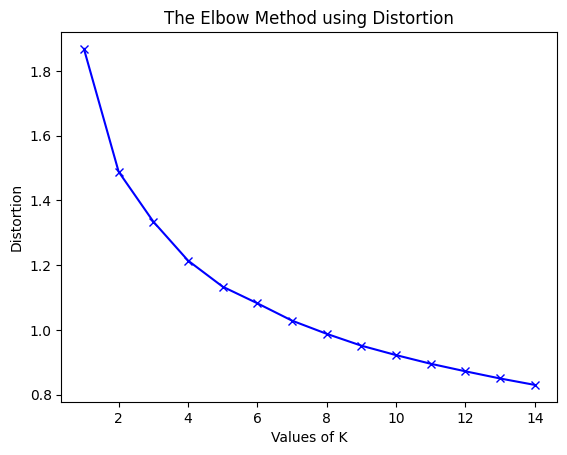

In [81]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

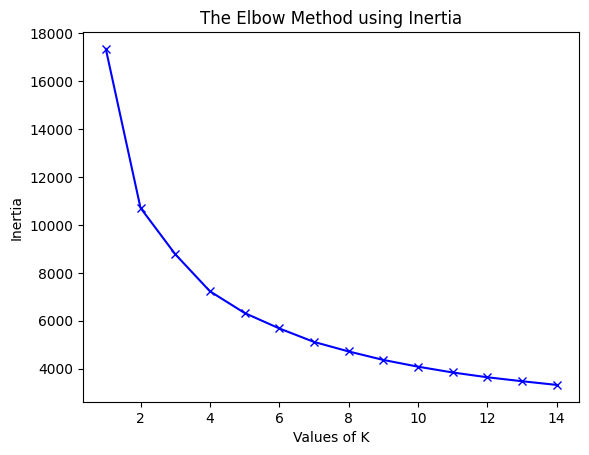

In [82]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [83]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

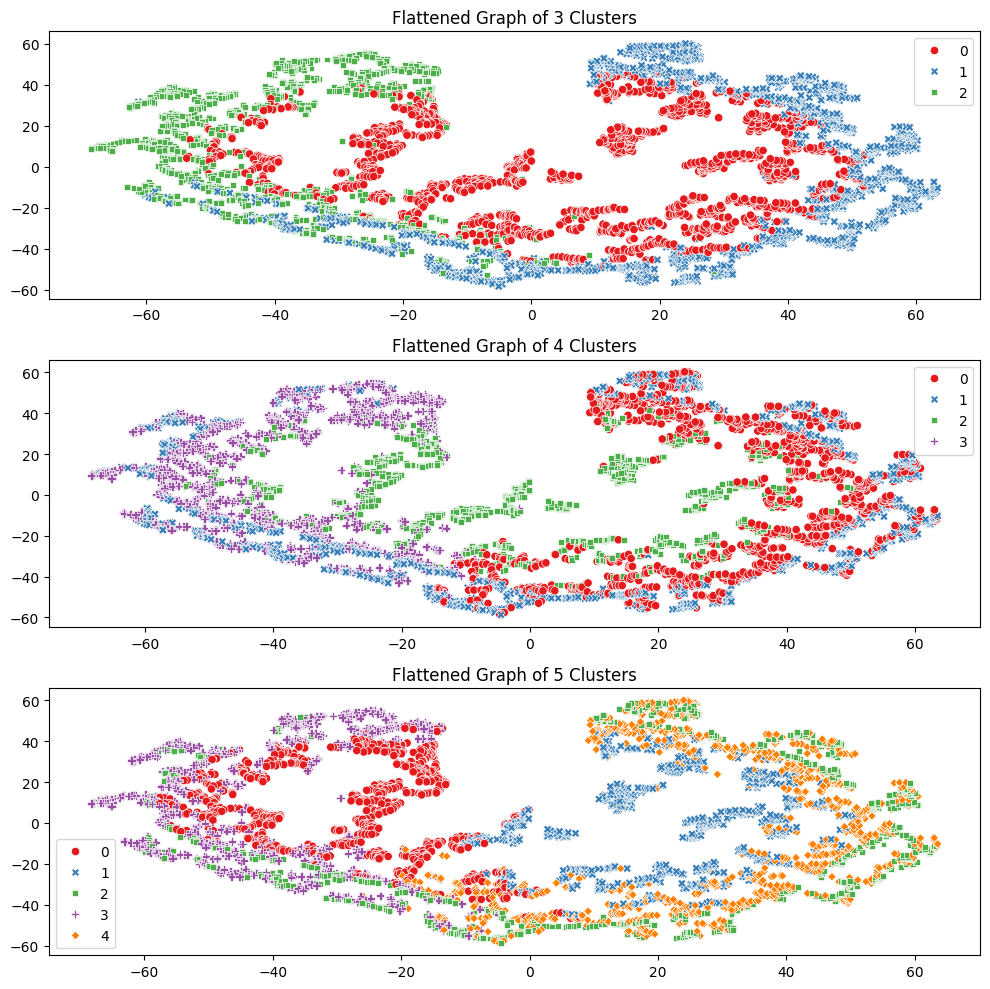

In [91]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()

In [85]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

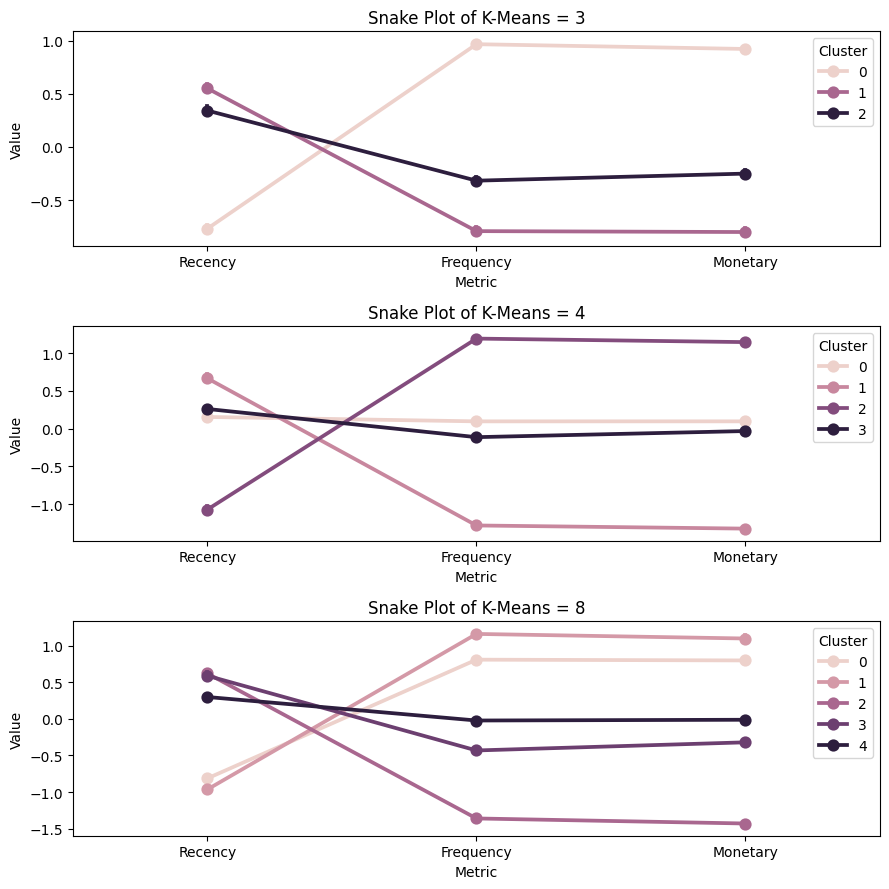

In [92]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 8')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()

In [93]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': ['mean','min', 'max'],
        'Frequency': ['mean','min', 'max'],
        'Monetary': ['mean','min', 'max','count']
    }).round(0)
    
    return df_new

In [94]:
rfm_values(df_rfm_k5)

Recency          Frequency           Monetary                     
           mean min  max      mean min   max     mean   min      max count
Cluster                                                                   
0          24.0   0  275     160.0  12  5111    541.0  27.0  33332.0   788
1          19.0   0  372     251.0  20  7847    733.0  88.0  26186.0   736
2         156.0   0  373       8.0   1    31     23.0   0.0    166.0   797
3         141.0   1  373      30.0   2   153    103.0   8.0   1304.0   880
4         104.0   1  373      48.0   1   238    146.0  19.0   2033.0  1137

In [95]:
df_rfm_k5 = df_rfm_k5[(df_rfm_k5.Monetary < df_rfm_k5.Monetary.quantile(0.95)) & 
           (df_rfm_k5.Frequency < df_rfm_k5.Frequency.quantile(0.95)) &
           (df_rfm_k5.Recency < df_rfm_k5.Recency.quantile(0.95) 
           )]

In [99]:
color_discrete_map = {'virginica': 'rgb(255,0,0)', 'setosa': 'rgb(0,255,0)', 'versicolor': 'rgb(0,0,255)'}

px.scatter(x=df_rfm_k5.Frequency, y=df_rfm_k5.Recency, size=df_rfm_k5.Monetary, color=df_rfm_k5.Cluster,
              color_discrete_map=color_discrete_map)